In [1]:
from nixtla import NixtlaClient
from datasetsforecast.long_horizon import LongHorizon
from utilsforecast.losses import mae, mape, rmse
nixtla_client = NixtlaClient(
    api_key = 'nixak-ZUBNbtRWb0JinHdA6NlRvMZkmH1YU7knytR4yi0JkGaBULEdSgElW5bKVIjf6RcXGdOSijcJSxAYvwzq'
)

nixtla_client.validate_api_key()


INFO:nixtla.nixtla_client:Happy Forecasting! :)


True

In [2]:
import pandas as pd
from datetime import timedelta
from nixtla import NixtlaClient
from utilsforecast.losses import mae

In [3]:
df = pd.read_csv('df.csv')
df["unique_id"] = 0
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True, drop=False)
df

,time,DAP,DAP 24H,DAP 7D,SCED,F_TLF,NG Price,Non-Renew,is_holiday,unique_id
time,,,,,,,,,,
2019-01-02 00:00:00,2019-01-02 00:00:00,23.9250,23.925000,23.925000,26.216109,0.016499,3.250000,36508.703164,0,0
2019-01-02 01:00:00,2019-01-02 01:00:00,23.3140,23.619500,23.619500,25.671136,0.016441,3.227917,35983.092128,0,0
2019-01-02 02:00:00,2019-01-02 02:00:00,23.3475,23.528833,23.528833,24.970952,0.016411,3.205833,35550.176684,0,0
2019-01-02 03:00:00,2019-01-02 03:00:00,23.0595,23.411500,23.411500,24.787712,0.016441,3.183750,35511.693684,0,0
2019-01-02 04:00:00,2019-01-02 04:00:00,25.2672,23.782640,23.782640,24.887786,0.016534,3.161667,36565.635248,0,0
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,2023-12-31 19:00:00,19.3715,17.351446,20.111057,14.422107,0.021356,2.580000,29417.400000,0,0
2023-12-31 20:00:00,2023-12-31 20:00:00,16.7739,17.394163,20.122605,12.597410,0.021367,2.580000,26543.200000,0,0
2023-12-31 21:00:00,2023-12-31 21:00:00,15.0035,17.432750,20.133511,10.170172,0.021383,2.580000,24706.800000,0,0


In [4]:
h = 24                              # hours ahead each run
context_days = 365                   # days of history
start_date = pd.Timestamp('2023-01-01')
end_date   = pd.Timestamp('2023-12-31')

In [5]:
from datetime import timedelta

# 1) List the extra feature columns you want to use
feature_cols = ['SCED', 'F_TLF', 'NG Price', 'Non-Renew']  # ← replace with your actual column names

all_fcsts = []
current = start_date
while current <= end_date:
    # build context window [current - context_days, current)
    window_end   = current - timedelta(hours=1)
    window_start = window_end - timedelta(days=context_days)
    
    # 2) HISTORY slice: include features + target
    hist = df.loc[window_start : window_end, 
                  ['unique_id','time','DAP'] + feature_cols] \
           .reset_index(drop=True)

    # 3) FUTURE exog slice: next 24 h of features
    future_start = current
    future_end   = current + timedelta(hours=h-1)
    future_exog = df.loc[future_start : future_end,
                         ['unique_id','time'] + feature_cols] \
                  .reset_index(drop=True)

    # 4) Forecast with both history and future exogenous
    fcst = nixtla_client.forecast(
        df            = hist,
        X_df          = future_exog,       # ← here’s where you plug in your features
        h             = h,
        level         = [90],
        finetune_steps= 10,
        finetune_loss = "mae",
        model         = "timegpt-1-long-horizon",
        id_col        = "unique_id",
        time_col      = "time",
        target_col    = "DAP",
    )

    all_fcsts.append(fcst)
    current += timedelta(days=1)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Using future exogenous features: ['SCED', 'F_TLF', 'NG Price', 'Non-Renew']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['SCED', 'F_TLF', 'NG Price', 'Non-Renew']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['SCED', 'F_TLF', 'NG Price', 'Non-Renew']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs.

In [6]:
pred_df = pd.concat(all_fcsts, ignore_index=True)

In [7]:
pred_df

,unique_id,time,TimeGPT,TimeGPT-hi-90,TimeGPT-lo-90
0,0,2023-01-01 00:00:00,0.406204,16.886070,-16.073662
1,0,2023-01-01 01:00:00,2.616680,21.947222,-16.713861
2,0,2023-01-01 02:00:00,2.003704,22.010193,-18.002785
3,0,2023-01-01 03:00:00,4.908062,29.028341,-19.212217
4,0,2023-01-01 04:00:00,8.208843,34.149475,-17.731789
...,...,...,...,...,...
8755,0,2023-12-31 19:00:00,16.391945,351.757050,-318.973180
8756,0,2023-12-31 20:00:00,14.302776,171.262240,-142.656680
8757,0,2023-12-31 21:00:00,12.960083,80.153534,-54.233370
8758,0,2023-12-31 22:00:00,12.804802,33.077700,-7.468100


In [8]:
df2 = df.reset_index(drop=True)
mask = df2['time'].isin(pred_df['time'])

actual = df2.loc[mask, ['unique_id','time','DAP']]


In [9]:
merged = actual.merge(
    pred_df[['unique_id','time','TimeGPT', 'TimeGPT-hi-90', 'TimeGPT-lo-90']],
    on=['unique_id','time'],
    how='inner'
)

evaluation = mae(
    merged,
    models     = ["TimeGPT"],
    id_col     = "unique_id",
    target_col = "DAP"
)
print("MAE:", evaluation)


MAE:    unique_id    TimeGPT
0          0  36.537084


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_day_forecast(date_str, merged_df, model_name='TimeGPT'):
    """
    Plots actual vs. predicted values with a 90% confidence interval
    for a single 24-hour period specified by `date_str` (YYYY-MM-DD).
    """
    # Convert date_str to datetime and define the 24h range
    date = pd.to_datetime(date_str).normalize()
    next_date = date + pd.Timedelta(days=1)

    # Select only the rows for that day
    mask = (merged_df['time'] >= date) & (merged_df['time'] < next_date)
    df_day = merged_df.loc[mask].copy()
    if df_day.empty:
        raise ValueError(f"No data for {date_str}")

    # Use the known CI column names for 90%
    lower_col = f"{model_name}-lo-90"
    upper_col = f"{model_name}-hi-90"
    if lower_col not in df_day.columns or upper_col not in df_day.columns:
        raise ValueError(
            f"Expected columns '{lower_col}' and '{upper_col}' not both found. "
            f"Available columns: {df_day.columns.tolist()}"
        )

    # Plot
    plt.figure()
    plt.plot(df_day['time'], df_day['DAP'],      label='Actual')
    plt.plot(df_day['time'], df_day[model_name], label='Prediction')
    plt.fill_between(
        df_day['time'],
        df_day[lower_col],
        df_day[upper_col],
        alpha=0.3,
        label='90% CI'
    )
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('DAP')
    plt.title(f"{model_name} Forecast vs Actual: {date.date()}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

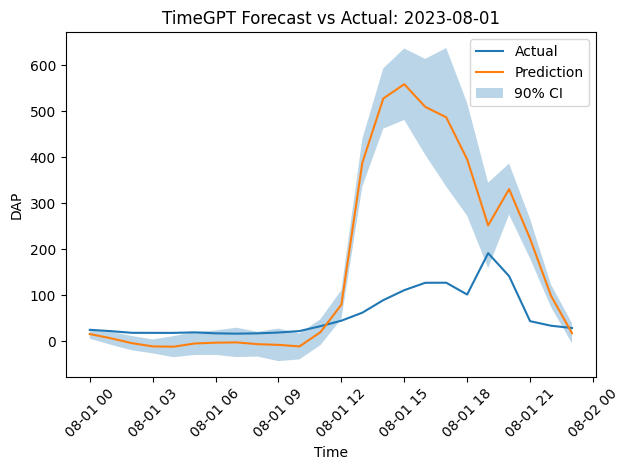

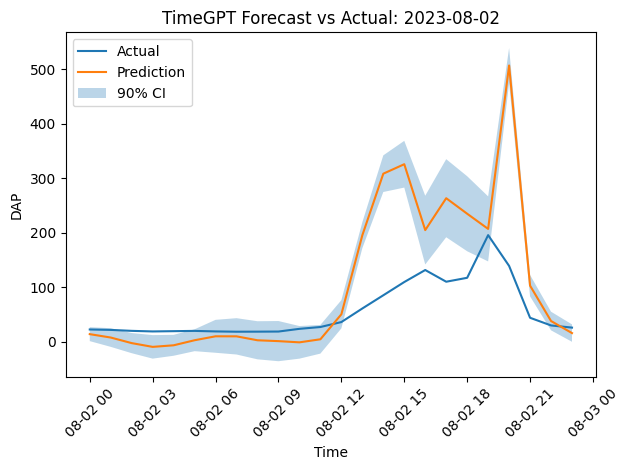

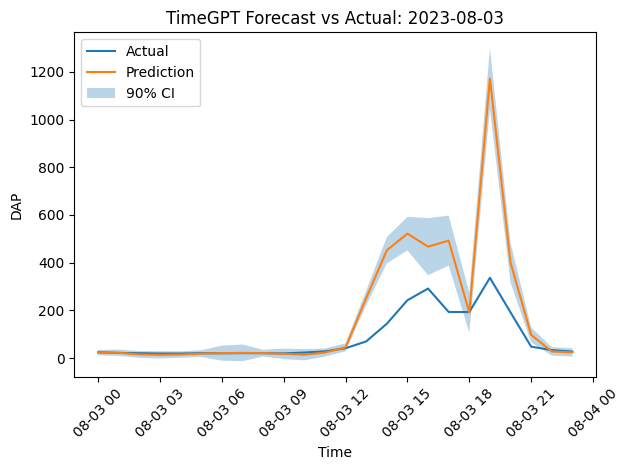

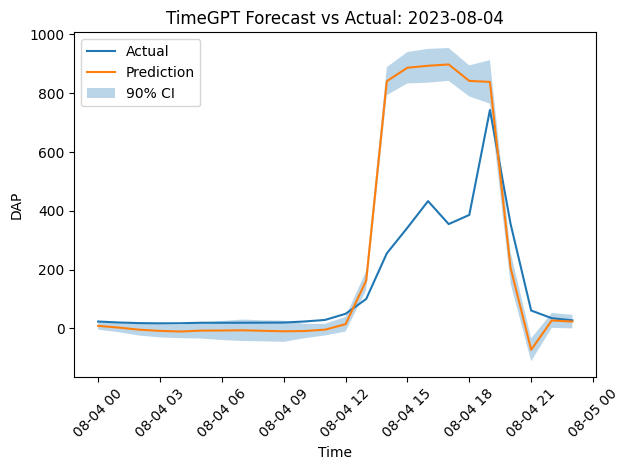

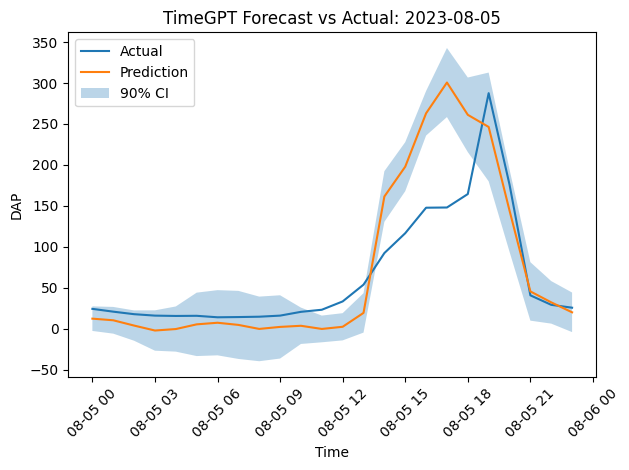

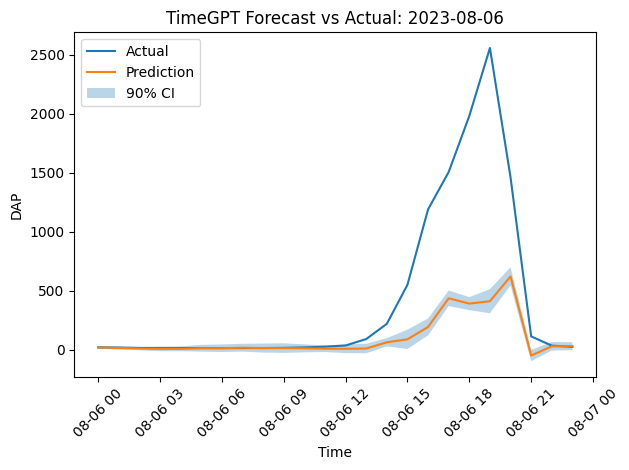

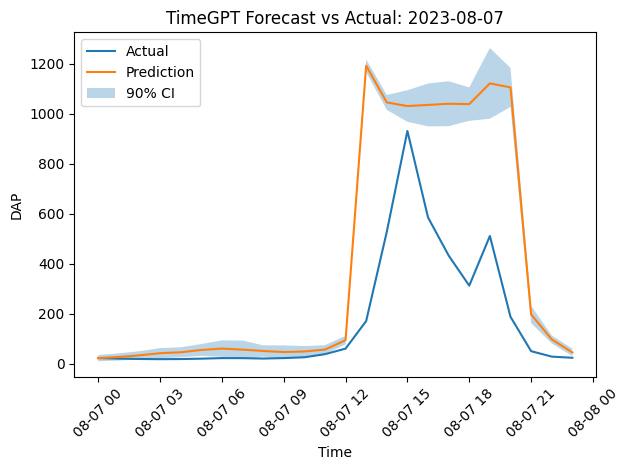

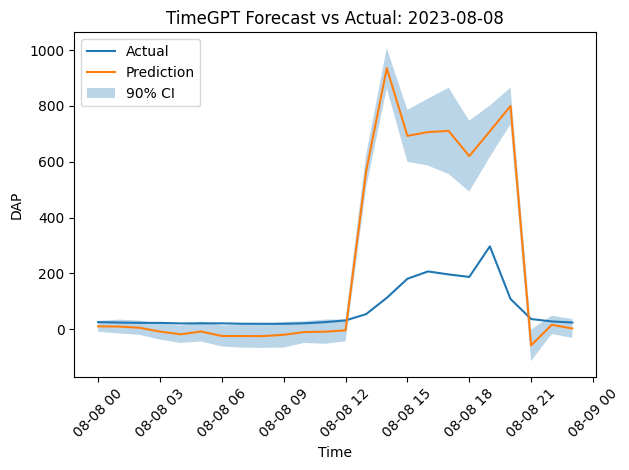

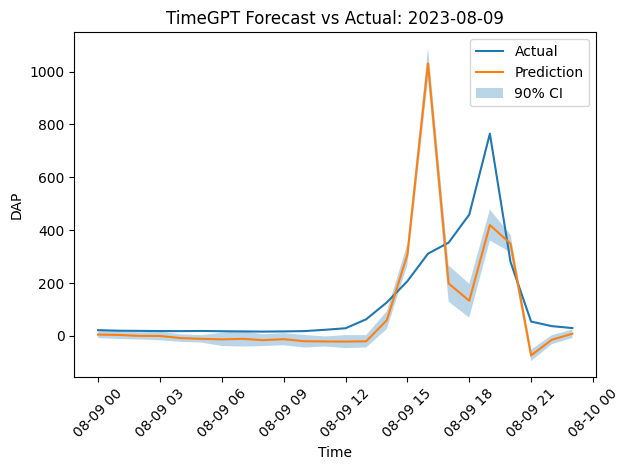

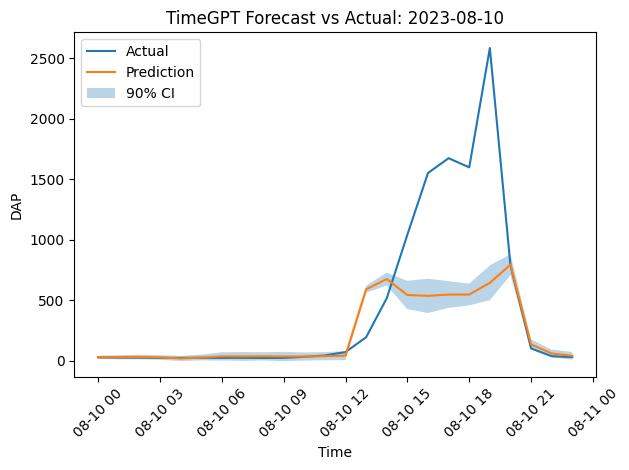

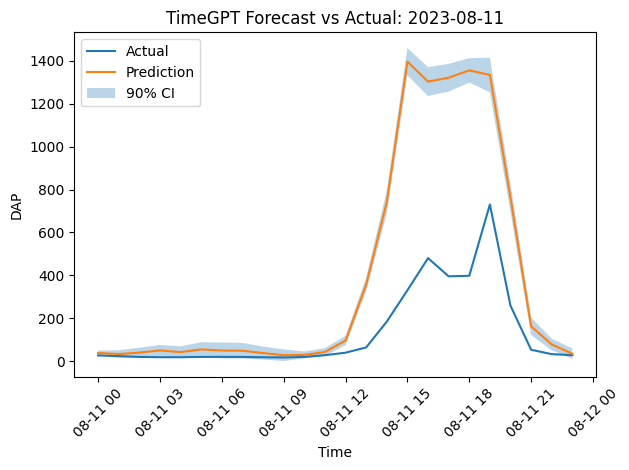

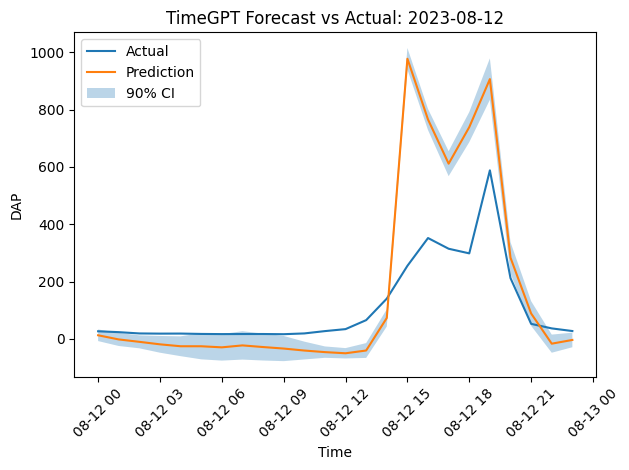

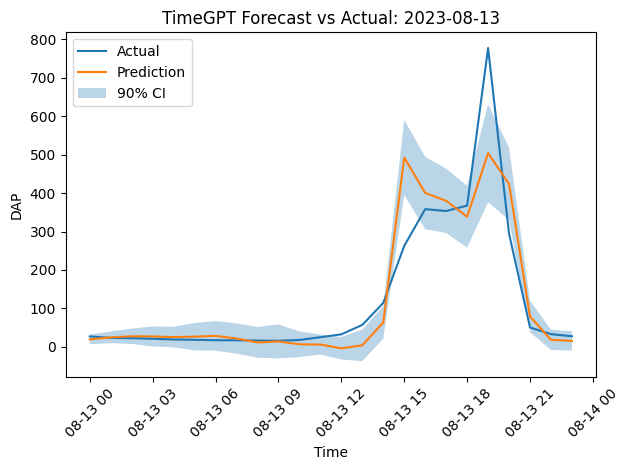

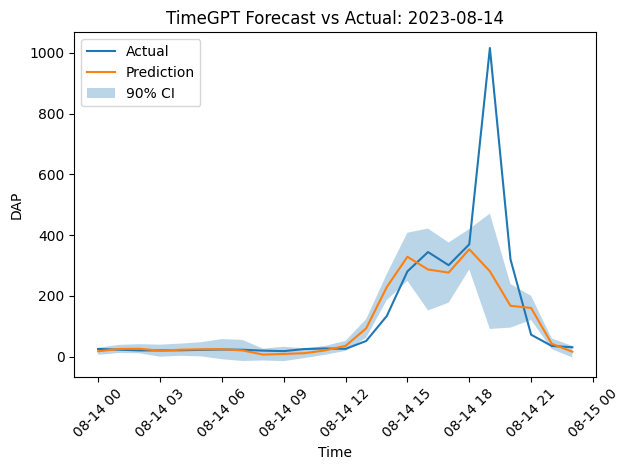

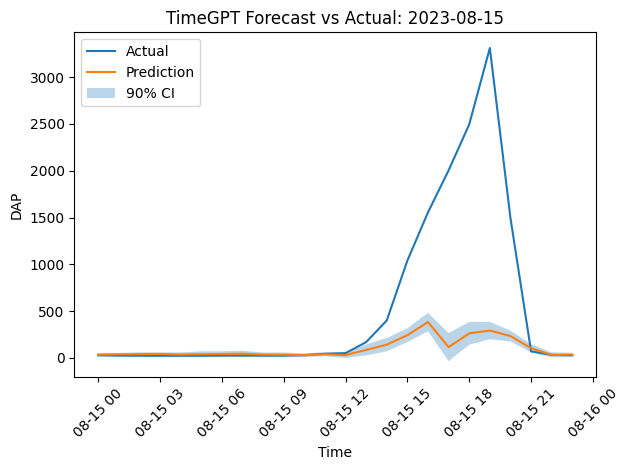

In [13]:
from datetime import datetime
start_date = datetime.strptime('2023-08-01', '%Y-%m-%d')
end_date = datetime.strptime('2023-08-15', '%Y-%m-%d')

current_date = start_date
while current_date <= end_date:
    plot_day_forecast(current_date.strftime('%Y-%m-%d'), merged)
    current_date += timedelta(days=1)

In [12]:
merged

,unique_id,time,DAP,TimeGPT,TimeGPT-hi-90,TimeGPT-lo-90
0,0,2023-01-01 00:00:00,10.83340,0.406204,16.886070,-16.073662
1,0,2023-01-01 01:00:00,10.22220,2.616680,21.947222,-16.713861
2,0,2023-01-01 02:00:00,8.73719,2.003704,22.010193,-18.002785
3,0,2023-01-01 03:00:00,8.19749,4.908062,29.028341,-19.212217
4,0,2023-01-01 04:00:00,8.33215,8.208843,34.149475,-17.731789
...,...,...,...,...,...,...
8755,0,2023-12-31 19:00:00,19.37150,16.391945,351.757050,-318.973180
8756,0,2023-12-31 20:00:00,16.77390,14.302776,171.262240,-142.656680
8757,0,2023-12-31 21:00:00,15.00350,12.960083,80.153534,-54.233370
8758,0,2023-12-31 22:00:00,15.76990,12.804802,33.077700,-7.468100
